# sentinelsat

In [37]:
# see https://sentinelsat.readthedocs.io/en/stable/index.html
# and the Sentinel user guide at https://sentinels.copernicus.eu/web/sentinel/user-guides

#%pip install --user sentinelsat

In [38]:
# connect to the OData API
#
# save credentials for scihub.copernicus.eu in $HOME/.netrc like this:
#
# machine scihub.copernicus.eu
#   login <your username>
#   password <your password>
# machine colhub.met.no
#   login <your username>
#   password <your password>
#
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

local_api = SentinelAPI(None, None, "https://colhub-archive.met.no")
api = SentinelAPI(None, None, "https://scihub.copernicus.eu/dhus")

data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/"

In [39]:
# get full metadata for a specific product
api.get_product_odata('838f54c9-6255-4a1d-9bf7-d6dda743fd38', full=True)

{'id': '838f54c9-6255-4a1d-9bf7-d6dda743fd38',
 'title': 'S1A_IW_GRDH_1SDV_20181126T142233_20181126T142258_024760_02B976_067A',
 'size': 999808860,
 'md5': '032b30ffebe0f2e6d026f9cd77417f57',
 'date': datetime.datetime(2018, 11, 26, 14, 22, 33, 47000),
 'footprint': 'POLYGON((-122.421036 42.884716,-125.507095 43.278706,-125.175270 44.777348,-122.010872 44.383575,-122.421036 42.884716))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('838f54c9-6255-4a1d-9bf7-d6dda743fd38')/$value",
 'Online': False,
 'Creation Date': datetime.datetime(2018, 11, 26, 17, 20, 26, 716000),
 'Ingestion Date': datetime.datetime(2018, 11, 26, 17, 2, 46, 675000),
 'Acquisition Type': 'NOMINAL',
 'Carrier rocket': 'Soyuz',
 'Cycle number': 156,
 'Date': datetime.datetime(2018, 11, 26, 14, 22, 33, 47000),
 'Filename': 'S1A_IW_GRDH_1SDV_20181126T142233_20181126T142258_024760_02B976_067A.SAFE',
 'Footprint': '<gml:Polygon srsName="http://www.opengis.net/gml/srs/epsg.xml#4326" xmlns:gml="http://www.op

In [40]:
# NOTE: Test data - overwritten by next cell

# Spatial locations
locations = [[4.4, 60.3],
             [3.4, 60.3],
             [3.4, 65.7]]

footprint_json = {
  "type": "Feature",
  "geometry": {
    "type": "MultiPoint",
    "coordinates": locations
  }
}
footprint = geojson_to_wkt(footprint_json)

# Time interval
start_times = "2022-09-25T00:00:00.000Z"
end_times = "2022-09-26T23:59:59.000Z"

In [41]:
# import dict containing metadata for in-situ data
# https://raw.githubusercontent.com/jerabaul29/MachineOcean_WP1_WHOI/main/mo_whoi_data/data_files/in_situ_dict.py
# from private repo at https://github.com/jerabaul29/MachineOcean_WP1_WHOI
import time
import os

os.environ["TZ"] = "UTC"
time.tzset()

import datetime
import pytz

utc_timezone = pytz.timezone("UTC")

wd = os.getcwd()

os.chdir("../../MachineOcean_WP1_WHOI/mo_whoi_data/data_files")

import in_situ_dict
in_situ_obs = in_situ_dict.get_in_situ_metadata()

os.chdir(wd)

# make list of in-situ locations to fetch sat data for, including start_time and end_time for each location timeseries
sites = []
locations = []
start_times = []
end_times = []

for site in in_situ_obs:
    sites.append(site)
    locations.append([in_situ_obs[site]["lon"][0], in_situ_obs[site]["lat"][0]])
    start_times.append(in_situ_obs[site]["datetime_start"])
    end_times.append(in_situ_obs[site]["datetime_end"])

In [42]:
print(in_situ_obs.keys())
print(sites)
print(locations)
print(start_times)
print(end_times)

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])
['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8']
[[-124.304, 44.6393], [-39.47378, 59.9337], [-125.03231666666667, 10.050801666666667], [-124.304, 44.6393], [-39.47378, 59.9337], [-70.7785, 40.1334], [-65.0, 38.318], [-124.304, 44.6393], [-70.7785, 40.1334], [-89.2069, -54.4041], [-124.304, 44.6393], [-70.7785, 40.1334], [-38.0, 24.5837], [-124.304, 44.6393], [-39.47378, 59.9337], [-70.7785, 40.1334], [-70.7785, 40.1334], [-70.7785, 40.1334]]
[datetime.datetime(2018, 9, 23, 5, 9, 59, 972136, tzinfo=<UTC>), datetime.datetime(2020, 8, 18, 0, 

In [43]:
# search by polygon, time, and SciHub query keywords - build dict with all relevant sat products, checking both scihub and local MET colhub
products_colhub = {}
products_scihub = {}

print("Finding products with colocations for {} in-situ observation sites.".format(len(locations)))

for (site, location, start_time, end_time) in zip(sites, locations, start_times, end_times):
    footprint_json = {
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": location
      }
    }
    footprint = geojson_to_wkt(footprint_json)

    products_colhub.update(local_api.query(footprint,
                        date=(start_time, end_time),
                        platformname="Sentinel-1",
                        producttype="GRD"))
                        #limit=1,
                        #cloudcoverpercentage=(0, 30)))

    scihub_results = api.query(footprint,
                        date=(start_time, end_time),
                        platformname="Sentinel-1",
                        producttype="GRD")
                        #limit=1,
                        #cloudcoverpercentage=(0, 30))

    products_scihub.update(scihub_results)

    # attach scihub products to relevant in-situ obs site
    in_situ_obs[site]["products"] = scihub_results
    
    time.sleep(2) # scihub does not like too eager scripts...

print("Sat products available on colhub.met.no: " + str(len(products_colhub)))
print("Sat products available on scihub.copernicus.eu/dhus: " + str(len(products_scihub)))

Finding products with colocations for 18 in-situ observation sites.


Querying products:  33%|###2      | 100/305 [00:00<?, ?product/s]

Querying products:  68%|######8   | 100/146 [00:00<?, ?product/s]

Querying products:  25%|##5       | 100/398 [00:00<?, ?product/s]

Sat products available on colhub.met.no: 0
Sat products available on scihub.copernicus.eu/dhus: 1054


Endurance_8 has 13 colocations
Irminger_7 has 305 colocations
SPURS2 has 0 colocations
Endurance_4 has 21 colocations
Irminger_6 has 146 colocations
Pioneer_5 has 6 colocations
CLIMODE has 0 colocations
Endurance_9 has 12 colocations
Pioneer_10 has 37 colocations
SouthernOcean2 has 0 colocations
Endurance_3 has 10 colocations
Pioneer_3 has 10 colocations
SPURS1 has 0 colocations
Endurance_7 has 28 colocations
Irminger_3 has 398 colocations
Pioneer_7 has 16 colocations
Pioneer_6 has 28 colocations
Pioneer_8 has 25 colocations
Total no of sat products: 1055


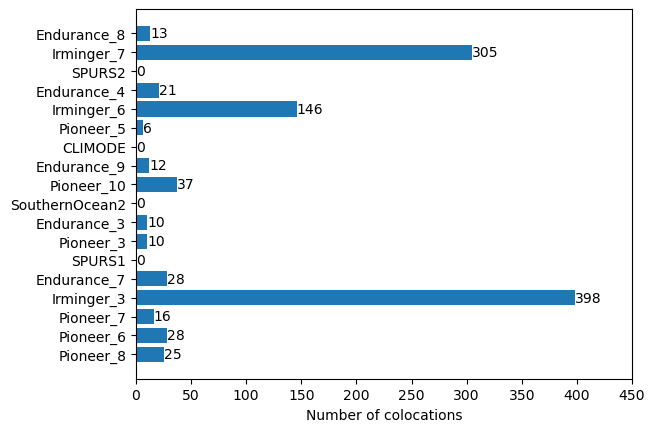

In [44]:
# how many colocations do we have? 
# (*assuming that there always are temporal colocations to be found as long as sat product is within in-situ obs start-end time interval)

sites = []
n_colocations = []
total_n_colocations = 0

for name, obs in in_situ_obs.items():
    sites.append(name)
    n = len(obs["products"].keys())
    n_colocations.append(n)
    total_n_colocations += n
    print("{} has {} colocations".format(name, n))

print("Total no of sat products: {}".format(total_n_colocations))

# visualize
fig, ax = plt.subplots()

y_pos = np.arange(len(sites))

hbars = ax.barh(y_pos, n_colocations, align='center')
ax.set_yticks(y_pos, labels=sites)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Number of colocations")

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%i')
ax.set_xlim(right=450)  # adjust xlim to fit labels

plt.show()

In [8]:
# are the products online or offline?
online = 0
offline = 0

for product_id in list(products_scihub.keys()):
    if api.is_online(product_id):
        online += 1
    else:
        offline += 1

print("{} online products and {} offline products available on scihub.".format(online, offline))


2 online products and 1052 offline products available on scihub.


From https://forum.step.esa.int/t/esa-copernicus-data-access-long-term-archive-and-its-drawbacks/15394 

[…] you try an bypass the quota restrictions by using multiple user accounts to access large volumes of data products from the LTA. Please note that the maximum number of products that a single user can request on SciHub is 1 every 30 minutes. An additional quota limit is applied to users of the APIHub of maximum 20 products every 12 hours. These restrictions are dictated by ESA and unless they change their policy then users will have to follow these guidelines. […]

Base on the long time archive (LTA) quota: 1000 products / 40 products per day = 25 days (not taking download time into account)

In [45]:
# convert to Pandas DataFrame
products_df = api.to_dataframe(products_scihub)

# GeoJSON FeatureCollection containing footprints and metadata of the scenes
products_geojson = api.to_geojson(products_scihub)

# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
products_gdf = api.to_geodataframe(products_scihub)

In [46]:
products_gdf

,title,link,link_alternative,link_icon,summary,ondemand,ingestiondate,beginposition,endposition,missiondatatakeid,...,polarisationmode,productclass,producttype,platformname,size,status,timeliness,uuid,processed,geometry
838f54c9-6255-4a1d-9bf7-d6dda743fd38,S1A_IW_GRDH_1SDV_20181126T142233_20181126T1422...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-26T14:22:33.047Z, Instrument: SA...",false,2018-11-26 17:02:46.675,2018-11-26 14:22:33.047,2018-11-26 14:22:58.046,178550,...,VV VH,S,GRD,Sentinel-1,1.59 GB,ARCHIVED,Fast-24h,838f54c9-6255-4a1d-9bf7-d6dda743fd38,NaN,"POLYGON ((-122.42104 42.88472, -125.50710 43.2..."
7b3ee3cd-8860-49d2-b08b-3aac8e4873b4,S1B_IW_GRDH_1SDV_20181122T020852_20181122T0209...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-22T02:08:52.289Z, Instrument: SA...",false,2018-11-22 13:11:08.195,2018-11-22 02:08:52.289,2018-11-22 02:09:17.286,104022,...,VV VH,S,GRD,Sentinel-1,1.62 GB,ARCHIVED,Fast-24h,7b3ee3cd-8860-49d2-b08b-3aac8e4873b4,NaN,"POLYGON ((-125.82740 45.27129, -122.55980 45.6..."
9a7be3d5-e1b8-44c4-a3d4-7d59b1d38d9e,S1A_IW_GRDH_1SDV_20181114T142233_20181114T1422...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-14T14:22:33.478Z, Instrument: SA...",false,2018-11-14 17:10:45.400,2018-11-14 14:22:33.478,2018-11-14 14:22:58.477,176903,...,VV VH,S,GRD,Sentinel-1,1.59 GB,ARCHIVED,Fast-24h,9a7be3d5-e1b8-44c4-a3d4-7d59b1d38d9e,NaN,"POLYGON ((-122.42115 42.88469, -125.50721 43.2..."
ebb185b2-cfc6-41f5-8bb7-042bbb781a0e,S1B_IW_GRDH_1SDV_20181113T142953_20181113T1430...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-13T14:29:53.626Z, Instrument: SA...",false,2018-11-13 19:10:59.890,2018-11-13 14:29:53.626,2018-11-13 14:30:18.626,103028,...,VV VH,S,GRD,Sentinel-1,1.6 GB,ARCHIVED,Fast-24h,ebb185b2-cfc6-41f5-8bb7-042bbb781a0e,NaN,"POLYGON ((-124.28217 43.59385, -127.43363 43.9..."
9847018a-bbbd-468a-b466-410f60477a88,S1A_IW_GRDH_1SDV_20181102T142233_20181102T1422...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-02T14:22:33.779Z, Instrument: SA...",false,2018-11-02 17:09:09.321,2018-11-02 14:22:33.779,2018-11-02 14:22:58.778,175259,...,VV VH,S,GRD,Sentinel-1,1.59 GB,ARCHIVED,Fast-24h,9847018a-bbbd-468a-b466-410f60477a88,NaN,"POLYGON ((-122.42085 42.88464, -125.50678 43.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01a8bd84-fb65-49f5-86ee-9da8daf05054,S1A_IW_GRDH_1SDV_20171127T224224_20171127T2242...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2017-11-27T22:42:24.293Z, Instrument: SA...",false,2017-11-28 04:09:29.508,2017-11-27 22:42:24.293,2017-11-27 22:42:49.291,135219,...,VV VH,S,GRD,Sentinel-1,1.61 GB,ARCHIVED,NaN,01a8bd84-fb65-49f5-86ee-9da8daf05054,NaN,"POLYGON ((-73.11754 40.46411, -70.09877 40.865..."
a4aaccb8-e659-4f42-8a51-1560ee658210,S1B_IW_GRDH_1SDV_20171127T104840_20171127T1049...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2017-11-27T10:48:40.37Z, Instrument: SAR...",false,2017-11-27 13:40:32.181,2017-11-27 10:48:40.370,2017-11-27 10:49:05.814,61453,...,VV VH,S,GRD,Sentinel-1,1.6 GB,ARCHIVED,NaN,a4aaccb8-e659-4f42-8a51-1560ee658210,NaN,"POLYGON ((-69.75826 39.70948, -72.67251 40.102..."
1ce1dd81-8eb4-4b5f-9eef-ec530a375f59,S1A_IW_GRDH_1SDV_20171115T22

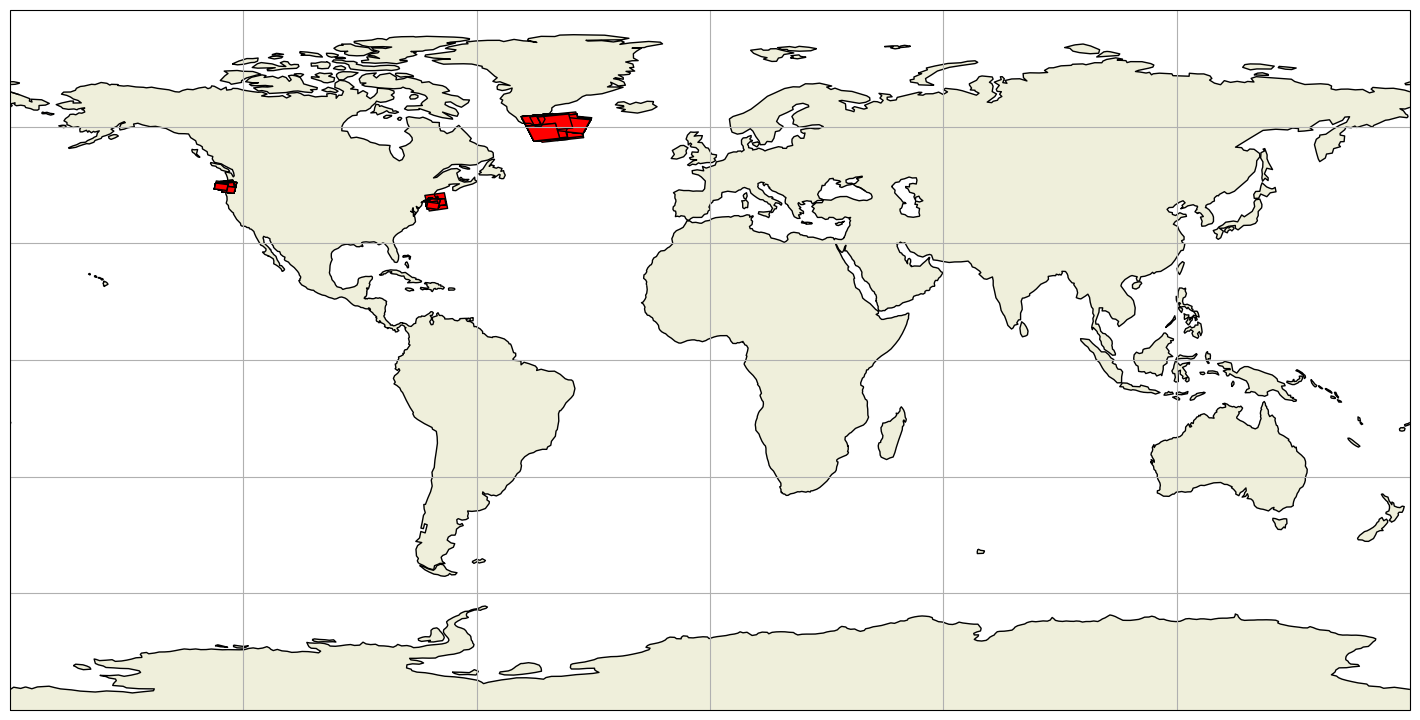

In [47]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import numpy as np

fig = plt.figure(figsize=(20, 20))

bounds = products_gdf.total_bounds

ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

#ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
#ax2.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
#ax2.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.COASTLINE)
#
#locations_np = np.array(locations)
#locs_x, locs_y = locations_np.T
#ax2.scatter(locs_x, locs_y, transform=ccrs.PlateCarree(), zorder=2)

plt.show()

In [49]:
#path_filter = make_path_filter("*s1?-*-grd-*.tiff") # all Sentinel 1 GRD products
#api.download_all(products_scihub, directory_path=data_dir)#, nodefilter=path_filter)

# 1st step: Download all Pioneer colocated products
download_products = {}

for name, obs in in_situ_obs.items():
    if "Pioneer" in name:
        print("Downloading {} products containing colocations with {}...".format(len(obs["products"].keys()), name), end="")
        api.download_all(obs["products"], directory_path=data_dir)
        print("done")

In [10]:
import zipfile
from os import path

# unzip all downloaded products
for product_name in products_gdf.title:
    zip_filename = data_dir + "{}.zip".format(product_name)
    safe_dir_name = data_dir + "{}.SAFE".format(product_name)

    if path.exists(zip_filename) and not path.exists(safe_dir_name):
        with zipfile.ZipFile(zip_filename,"r") as zip_ref:
            zip_ref.extractall(data_dir)

In [13]:
# Clone nansat and add to $PYTHONPATH
#!git clone git@github.com:nansencenter/nansat.git
import sys
sys.path.append("./nansat")

# Install nansat dependency (not found in conda env production-10-2022)
#%pip install --user pythesint

# TODO: plot a product – original and normalized side-by-side CONT HERE!


Note: you may need to restart the kernel to use updated packages.


# pytroll

## NOTE: We have decided to go for nansat, so the following "code experiments" are no longer relevant.

In [2]:
# see http://pytroll.github.io/

%pip install --user satpy rioxarray rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 113.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Created wheel for satpy: filename=satpy-0.37.1-py2.py3-none-any.whl size=1308928 sha256=21b6993ee16ac37dea8383ffa54426f1e3eff2efef6b0c968ec4ea

In [3]:
from satpy.utils import check_satpy

check_satpy()

Readers
abi_l1b:  ok
abi_l1b_scmi:  ok
abi_l2_nc:  ok
acspo:  ok
agri_l1:  ok
ahi_hrit:  ok
ahi_hsd:  ok
ahi_l1b_gridded_bin:  ok
ami_l1b:  cannot find module 'satpy.readers.ami_l1b' (No module named 'pyspectral')
amsr2_l1b:  ok
amsr2_l2:  ok
amsr2_l2_gaasp:  ok
amsub_l1c_aapp:  ok
ascat_l2_soilmoisture_bufr:  ok
avhrr_l1b_aapp:  ok
avhrr_l1b_eps:  ok
avhrr_l1b_gaclac:  cannot find module 'satpy.readers.avhrr_l1b_gaclac' (No module named 'pygac')
avhrr_l1b_hrpt:  cannot find module 'satpy.readers.hrpt' (No module named 'geotiepoints')
avhrr_l1c_eum_gac_fdr_nc:  ok
caliop_l2_cloud:  cannot find module 'satpy.readers.caliop_l2_cloud' (No module named 'pyhdf')
clavrx:  cannot find module 'satpy.readers.clavrx' (No module named 'pyhdf')
cmsaf-claas2_l2_nc:  ok
electrol_hrit:  ok
fci_l1c_nc:  ok
fci_l2_nc:  ok
generic_image:  ok
geocat:  ok
ghrsst_l2:  ok
glm_l2:  ok
goes-imager_hrit:  ok
goes-imager_nc:  ok
gpm_imerg:  ok
grib:  ok
hsaf_grib:  ok
hy2_scat_l2b_h5:  ok
iasi_l2:  ok
iasi_l2_s

In [15]:
from satpy import Scene, find_files_and_readers
from datetime import datetime
import zipfile
from os import path
import glob

for product_name in products_gdf.title:
    zip_filename = data_dir + "{}.zip".format(product_name)
    safe_dir_name = data_dir + "{}.SAFE".format(product_name)

    if not path.exists(safe_dir_name):
        with zipfile.ZipFile(zip_filename,"r") as zip_ref:
            zip_ref.extractall(data_dir)

In [27]:
import os
print(os.listdir(data_dir + "S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE"))

files = find_files_and_readers(
    base_dir=data_dir + "S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE",
    reader="sar-c_safe")

['S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE-report-20220925T180337.pdf', 'preview', 'support', 'manifest.safe', 'measurement', 'annotation']


ValueError: No supported files found

In [17]:
from satpy.dataset import DataQuery

scn = Scene(filenames=files)

scn.available_dataset_names()
scn.available_composite_names()

['sar-ice',
 'sar-ice-iw',
 'sar-ice-legacy',
 'sar-ice-log',
 'sar-ice-log-iw',
 'sar-land',
 'sar-land-iw',
 'sar-quick',
 'sar-rgb']

In [14]:
vh_id = DataQuery(name="measurement", polarization="vh")
scn.load([vh_id])
scn[vh_id]

ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found


<xarray.DataArray (y: 16678, x: 26733)>
dask.array<clip, shape=(16678, 26733), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) int64 0 1 2 3 4 5 6 ... 16672 16673 16674 16675 16676 16677
  * x            (x) int64 0 1 2 3 4 5 6 ... 26727 26728 26729 26730 26731 26732
    band         int64 1
    spatial_ref  int64 0
    crs          object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs
Attributes:
    name:                 measurement
    sensor:               sar-c
    wavelength:           [5.4, 5.405, 5.41]
    resolution:           80
    polarization:         vh
    calibration:          gamma
    quantity:             natural
    coordinates:          ('longitude', 'latitude')
    file_type:            safe_measurement
    standard_name:        backscatter
    units:                1
    modifiers:            ()
    platform_name:        s1b
    start_time:           2021-12-15 06:10:27
    end_time:             2021-12-15 06:10:52
    reader:               sar-c_safe
    area:                 Shape: (16678, 26733)\nLons: <xarray.DataArray 'int...
    _satpy_id:            DataID(name='measurement', polarization='vh', resol...
    ancillary_variables:  []

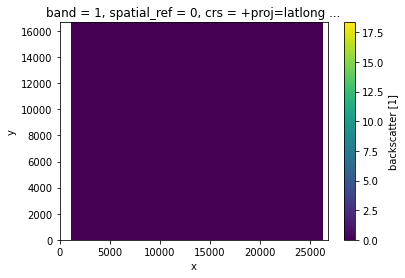

In [16]:
# To save as Geotiff (including the GCPs):
#scn.save_dataset(vh_id)

# XXX: Takes forever... investigate further
scn[vh_id].plot.imshow()

# XXX: Check out https://python-kurs.github.io/sommersemester_2019/units/S01E06.html 
# and https://nbviewer.org/github/pytroll/pytroll-examples/ ?